# Predcition of Hospital Admission Related to Otitis Externa

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to otitis externa. We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'ot_externa_date_'+str(i), 'ot_externa_ab_date_'+str(i), 'ot_externa_ab_type_'+str(i),
                   'incdt_ot_externa_date_'+str(i), 'admitted_ot_externa_date_'+str(i), 'sgss_gp_cov_ot_externa_date_'+str(i)]]
    
    #drop rows with no ot_externa reord
    datum = datum[datum['ot_externa_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with ot_externa_i
    datum = datum[datum['sgss_gp_cov_ot_externa_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'ot_externa_date_'+str(i): 'ot_externa_date', 'ot_externa_ab_date_'+str(i): 'ot_externa_ab_date', 
                           'ot_externa_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_ot_externa_date_'+str(i): 'incdt_ot_externa_date', 'incdt_ot_externa_type_'+str(i): 'incdt_ot_externa_type',
                           'admitted_ot_externa_date_'+str(i): 'admitted_ot_externa_date',
                           'sgss_gp_cov_ot_externa_date_'+str(i): 'sgss_gp_cov_ot_externa_date'},
                inplace=True)
    
    return datum

In [6]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [ ]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
def cox_build(infection, infection_type, data, data_no_abs): #data_ot_externa_incdt, data_ot_externa_no_abs_incdt
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_ot_externa_admitted',
            event_col='event_ot_externa_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_ot_externa_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a column for prescribed antibiotics
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_ot_externa_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [8]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [9]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex']]).toarray())#, 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex']].columns)#, 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season'
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)#, random_state=42)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [10]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [11]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_ot_externa.csv.gz')

In [12]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [13]:
#process 20 ot_externas and concatenate them 
data_ot_externa_1 = proc_infec_data(data,1)
data_ot_externa_2 = proc_infec_data(data,2)
data_ot_externa_3 = proc_infec_data(data,3)
data_ot_externa_4 = proc_infec_data(data,4)
data_ot_externa_5 = proc_infec_data(data,5)
data_ot_externa_6 = proc_infec_data(data,6)
data_ot_externa_7 = proc_infec_data(data,7)
data_ot_externa_8 = proc_infec_data(data,8)
data_ot_externa_9 = proc_infec_data(data,9)
data_ot_externa_10 = proc_infec_data(data,10)
data_ot_externa_11 = proc_infec_data(data,11)
data_ot_externa_12 = proc_infec_data(data,12)
data_ot_externa_13 = proc_infec_data(data,13)
data_ot_externa_14 = proc_infec_data(data,14)
data_ot_externa_15 = proc_infec_data(data,15)
data_ot_externa_16 = proc_infec_data(data,16)
data_ot_externa_17 = proc_infec_data(data,17)
data_ot_externa_18 = proc_infec_data(data,18)
data_ot_externa_19 = proc_infec_data(data,19)
data_ot_externa_20 = proc_infec_data(data,20)

data_ot_externa = pd.concat([data_ot_externa_1, data_ot_externa_2, data_ot_externa_3, data_ot_externa_4, data_ot_externa_5, data_ot_externa_6, data_ot_externa_7, data_ot_externa_8, data_ot_externa_9, data_ot_externa_10, data_ot_externa_11, data_ot_externa_12, data_ot_externa_13, data_ot_externa_14, data_ot_externa_15, data_ot_externa_16, data_ot_externa_17, data_ot_externa_18, data_ot_externa_19, data_ot_externa_20])
data_ot_externa.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [14]:
##add variable season
#convert data types
data_ot_externa['ot_externa_date'] = data_ot_externa['ot_externa_date'].astype('datetime64[ns]')
data_ot_externa['admitted_ot_externa_date'] = data_ot_externa['admitted_ot_externa_date'].astype('datetime64[ns]')
data_ot_externa.died_date = data_ot_externa.died_date.astype('datetime64[ns]')
data_ot_externa.deregistered_date = data_ot_externa.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_ot_externa['date'] = data_ot_externa['ot_externa_date'] 
data_ot_externa['date'] = data_ot_externa['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_ot_externa with today's date in year and month
data_ot_externa = data_ot_externa[data_ot_externa['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_ot_externa = data_ot_externa[data_ot_externa['date'] != last_1_month_date_y_m]
data_ot_externa = data_ot_externa[data_ot_externa['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of ot_externa records
data_ot_externa['season'] = np.nan
data_ot_externa['date_month'] = pd.DatetimeIndex(data_ot_externa['date']).month

conditions = [
    (data_ot_externa['date_month'] >= 3) & (data_ot_externa['date_month'] <= 5),
    (data_ot_externa['date_month'] >= 6) & (data_ot_externa['date_month'] <= 8),
    (data_ot_externa['date_month'] >= 9) & (data_ot_externa['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_ot_externa['season'] = np.select(conditions, choices, default='winter')

In [15]:
#add variable time period
data_ot_externa.loc[(data_ot_externa['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_ot_externa.loc[((data_ot_externa['date'] >= '2020-01') & (data_ot_externa['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_ot_externa.loc[(data_ot_externa['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

In [16]:
data_ot_externa['date'].max()

'2023-03'

#### event and duration

In [17]:
#scenario 1
#not hosped (nothing happened)
data_ot_externa.loc[data_ot_externa['admitted_ot_externa_date'].isnull(), 'event_ot_externa_admitted'] = 0

In [18]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_ot_externa['delta_ot_externa_admitted'] = (data_ot_externa['admitted_ot_externa_date'] - data_ot_externa['ot_externa_date']).dt.days
data_ot_externa.loc[((data_ot_externa['delta_ot_externa_admitted'] >= 0) & (data_ot_externa['delta_ot_externa_admitted'] <= 30)), 'event_ot_externa_admitted'] = 1

#scenario 2
#drop whoever was admitted before ot_externa consultation, i.e. negative value for delta_ot_externa_admitted
data_ot_externa = data_ot_externa[~(data_ot_externa['delta_ot_externa_admitted'] < 0)]

In [19]:
#scenario 3
#censor died patients
data_ot_externa['delta_admitted_died'] = (data_ot_externa['died_date'] - data_ot_externa['admitted_ot_externa_date']).dt.days
data_ot_externa.loc[data_ot_externa['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_ot_externa.loc[((data_ot_externa['delta_admitted_died'] >= 0) & (data_ot_externa['delta_admitted_died'] <= 30)), 'event_ot_externa_admitted'] = 0

#scenario 3
#censor deregistered patients
data_ot_externa['delta_admitted_deregistered'] = (data_ot_externa['deregistered_date'] - data_ot_externa['admitted_ot_externa_date']).dt.days
data_ot_externa.loc[data_ot_externa['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_ot_externa.loc[((data_ot_externa['delta_admitted_deregistered'] > 0) & (data_ot_externa['delta_admitted_deregistered'] <= 30)), 'event_ot_externa_admitted'] = 0

#agg scenario 3s
data_ot_externa['delta_admitted_died_deregistered'] = data_ot_externa['delta_admitted_deregistered'].combine_first(data_ot_externa['delta_admitted_died'])
data_ot_externa.loc[data_ot_externa['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [20]:
#scenario 1
#any other patients (nothing happened)
data_ot_externa['event_ot_externa_admitted'] = data_ot_externa['event_ot_externa_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_ot_externa['duration_ot_externa_admitted'] = data_ot_externa['delta_ot_externa_admitted'].combine_first(data_ot_externa['delta_admitted_died_deregistered'])
data_ot_externa['duration_ot_externa_admitted'] = data_ot_externa['duration_ot_externa_admitted'].replace(np.NaN, 30)
data_ot_externa.loc[(data_ot_externa['duration_ot_externa_admitted'] > 30), 'duration_ot_externa_admitted'] = 30

#give value 1 to event_ot_externa_admitted if duration_ot_externa_admitted is greater or equal to 0 and less than 30
data_ot_externa.loc[((data_ot_externa['duration_ot_externa_admitted'] >= 0) & (data_ot_externa['duration_ot_externa_admitted'] < 30)), 'event_ot_externa_admitted'] = 1

#drop any rows with value 0 in duration column
data_ot_externa = data_ot_externa[~(data_ot_externa['duration_ot_externa_admitted'] == 0)]

In [21]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_ot_externa.loc[((data_ot_externa['delta_ot_externa_admitted'] > 0) & (data_ot_externa['delta_ot_externa_admitted'] < 30)), 'event_ot_externa_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [22]:
#drop anybody with age less than 18 or 0!
data_ot_externa = data_ot_externa[~(data_ot_externa['age'] < 18)] 
data_ot_externa['age'][data_ot_externa['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_ot_externa = data_ot_externa[data_ot_externa['age_cat'] != '0-4']
data_ot_externa = data_ot_externa[data_ot_externa['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_ot_externa['bmi'][data_ot_externa['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_ot_externa['bmi'] = data_ot_externa['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_ot_externa['antibacterial_brit'][data_ot_externa['antibacterial_brit'] < 0] = np.nan

In [23]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_ot_externa = data_ot_externa.replace({"sex": dict_sex})
data_ot_externa = data_ot_externa.replace({"smoking": dict_smoking})

In [24]:
#drop rows with missing region
if ('region' in data_ot_externa.columns) and (data_ot_externa['region'].isnull().sum() > 0):
   data_ot_externa = data_ot_externa[data_ot_externa['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_ot_externa.columns) and (data_ot_externa['antibacterial_brit'].isnull().sum() > 0):
    data_ot_externa['antibacterial_brit'] = data_ot_externa['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_ot_externa.columns) and (data_ot_externa['ethnicity'].isnull().sum() > 0):
    data_ot_externa['ethnicity'] = data_ot_externa['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_ot_externa.columns) and (data_ot_externa['smoking'].isnull().sum() > 0):
    data_ot_externa['smoking'] = data_ot_externa['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_ot_externa.columns) and (data_ot_externa['imd'].isnull().sum() > 0):
    data_ot_externa['imd'] = data_ot_externa['imd'].fillna(0)

In [25]:
#missing values of bmi assign 5 and 0; categorise bmi
data_ot_externa['bmi_cat'] = 5

for idx, x in enumerate(data_ot_externa['bmi_cat']):
    if data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi')] >= 30:
        data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi')] >= 25) and (data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi')] < 30):
        data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi')] >= 18.5) and (data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi')] < 25):
        data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi')] < 18.5:
        data_ot_externa.iat[idx, data_ot_externa.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_ot_externa.columns) and (data_ot_externa['bmi_cat'].isnull().sum() > 0):
    data_ot_externa['bmi_cat'] = data_ot_externa['bmi_cat'].fillna(0)

In [26]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_ot_externa.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_ot_externa['ab_type_cat'] = np.where(data_ot_externa['ab_type'].isin(ab_series[mask].index),'other',data_ot_externa['ab_type'])
#assign no to non ab users
data_ot_externa.loc[data_ot_externa['ot_externa_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_ot_externa['ab_type_cat'] = data_ot_externa['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [27]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_ot_externa = data_ot_externa.replace({"sex": dict_sex})
data_ot_externa = data_ot_externa.replace({"ethnicity": dict_ethnicity})
data_ot_externa = data_ot_externa.replace({"smoking": dict_smoking})
data_ot_externa = data_ot_externa.replace({"imd": dict_imd})
data_ot_externa = data_ot_externa.replace({"bmi_cat": dict_bmi})
data_ot_externa = data_ot_externa.replace({"flu_vaccine": dict_flu})
data_ot_externa = data_ot_externa.replace({"region": dict_region})
data_ot_externa = data_ot_externa.replace({"age_cat": dict_age})
data_ot_externa = data_ot_externa.replace({"ab_type_cat": dict_ab_type})

In [28]:
data_ot_externa.ethnicity.value_counts('NA')

white      0.597501
unknown    0.252589
other      0.075042
asian      0.074868
Name: ethnicity, dtype: float64

In [29]:
data_ot_externa.smoking.value_counts('NA')

unknown         0.413488
smoker          0.390993
never_smoked    0.131293
ex_smoker       0.064226
Name: smoking_status, dtype: float64

In [30]:
data_ot_externa.bmi_cat.value_counts('NA')

obese             0.518261
unknown           0.255440
overweight        0.112080
healthy_weight    0.081755
underweight       0.032464
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [31]:
#categorise CCI
data_ot_externa['CCI_cat'] = pd.cut(data_ot_externa['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_ot_externa['antibacterial_brit'].clip(0, data_ot_externa['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

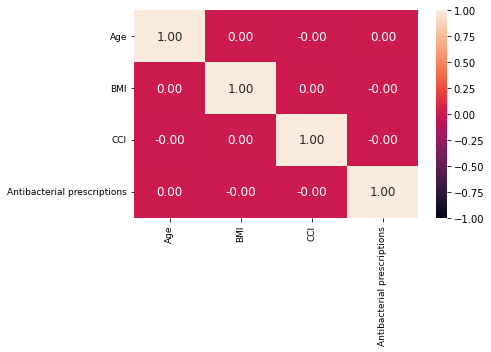

In [32]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_ot_externa[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_ot_externa/corr_ot_externa.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [33]:
data_ot_externa = data_ot_externa[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'ot_externa_ab_date', 'ab_type_cat', 'incdt_ot_externa_date', 'date', 'period',
                                   'event_ot_externa_admitted', 'duration_ot_externa_admitted'
                                    ]]

In [34]:
#switch variable ot_externa_ab_date into a binary variable
data_ot_externa[['ab_binary']] = data_ot_externa[['ot_externa_ab_date']].where(data_ot_externa[['ot_externa_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_ot_externa_incdt = data_ot_externa[data_ot_externa['incdt_ot_externa_date'] == 0]
data_ot_externa_prevl = data_ot_externa[data_ot_externa['incdt_ot_externa_date'] == 1]

#no antibiotics and incident hospital admission
data_ot_externa_no_abs_incdt = data_ot_externa_incdt[data_ot_externa_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_ot_externa_abs_incdt = data_ot_externa_incdt[data_ot_externa_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_ot_externa_no_abs_prevl = data_ot_externa_prevl[data_ot_externa_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_ot_externa_abs_prevl = data_ot_externa_prevl[data_ot_externa_prevl['ab_binary'] == 1]

In [35]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_ot_externa_incdt_prepandemic = data_ot_externa_incdt[data_ot_externa_incdt['period'] == 'prepandemic']
data_ot_externa_incdt_during_pandemic = data_ot_externa_incdt[(data_ot_externa_incdt['period'] == 'during_pandemic')]
data_ot_externa_incdt_post_2nd_lockdown = data_ot_externa_incdt[data_ot_externa_incdt['period'] == 'post_2nd_lockdown']
data_ot_externa_prevl_prepandemic = data_ot_externa_prevl[data_ot_externa_prevl['period'] == 'prepandemic']
data_ot_externa_prevl_during_pandemic = data_ot_externa_prevl[(data_ot_externa_prevl['period'] == 'during_pandemic')]
data_ot_externa_prevl_post_2nd_lockdown = data_ot_externa_prevl[data_ot_externa_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_ot_externa_no_abs_incdt_prepandemic = data_ot_externa_incdt_prepandemic[data_ot_externa_incdt_prepandemic['ab_binary'] == 0]
data_ot_externa_no_abs_incdt_during_pandemic = data_ot_externa_incdt_during_pandemic[data_ot_externa_incdt_during_pandemic['ab_binary'] == 0]
data_ot_externa_no_abs_incdt_post_2nd_lockdown = data_ot_externa_incdt_post_2nd_lockdown[data_ot_externa_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_ot_externa_no_abs_prevl_prepandemic = data_ot_externa_prevl_prepandemic[data_ot_externa_prevl_prepandemic['ab_binary'] == 0]
data_ot_externa_no_abs_prevl_during_pandemic = data_ot_externa_prevl_during_pandemic[data_ot_externa_prevl_during_pandemic['ab_binary'] == 0]
data_ot_externa_no_abs_prevl_post_2nd_lockdown = data_ot_externa_prevl_post_2nd_lockdown[data_ot_externa_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [36]:
#store data for plotting hosp admission counts and percentages
%store data_ot_externa
# save data
data_ot_externa.to_csv('../output/hospitalisation_prediction_ot_externa/data_ot_externa.csv')

Stored 'data_ot_externa' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-1- summary tables

In [ ]:
#make summary tables
make_summary_table('ot_externa', 'no_abs_incdt', data_ot_externa_no_abs_incdt)
make_summary_table('ot_externa', 'abs_incdt', data_ot_externa_abs_incdt)
make_summary_table('ot_externa', 'no_abs_prevl', data_ot_externa_no_abs_prevl)
make_summary_table('ot_externa', 'abs_prevl', data_ot_externa_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 108393 total observations, 107734 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 108393
number of events observed = 659
   partial log-likelihood = -7616.00
         time fit was run = 2023-06-28 14:51:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.11       0.90       0.11            -0.33             0.11                 0.72                 1.12
CCI_cat[T.medium]               -0.08       0.92       0.12            -0.33             0.16                 0.72                 1.18
CCI_cat[T.high]                 -0.14       0.87       0.15            -0.44             0.16                 0.64                 1.17
CCI_cat[T.very_high]            -0.13       0.88       0.13            -0.39             0.13                 0.67                 1.14
age_cat[T.25_34]                 0.22       1.25       0.15            -0.07             0.52                 0.93                 1.67
age_cat[T.35_44]                 0.09       1.10       0.15            -0.21             0.39                 0.81                 1.48
age_cat[T.45_54]                 0.25       1.28       0.15            -0.04             0.54                 0.96                 1.71
age_cat[T.55_64]                 0.01       1.01       0.16            -0.29             0.32                 0.75                 1.38
age_cat[T.65_74]                 0.12       1.13       0.15            -0.18             0.42                 0.84                 1.52
age_cat[T.75_more]               0.30       1.35       0.15             0.01             0.59                 1.01                 1.80
antibacterial_brit               0.01       1.01       0.03            -0.05             0.06                 0.96                 1.06
bmi_cat[T.obese]                 0.11       1.12       0.16            -0.20             0.41                 0.82                 1.51
bmi_cat[T.overweight]           -0.01       0.99       0.19            -0.38             0.37                 0.68                 1.45
bmi_cat[T.underweight]           0.38       1.46       0.24            -0.10             0.85                 0.91                 2.34
bmi_cat[T.unknown]               0.25       1.28       0.16            -0.07             0.57                 0.93                 1.76
ethnicity[T.other]               0.04       1.05       0.19            -0.34             0.43                 0.71                 1.53
ethnicity[T.unknown]            -0.16       0.85       0.16            -0.47             0.16                 0.62                 1.17
ethnicity[T.white]              -0.04       0.96       0.15            -0.33             0.25                 0.72                 1.29
flu_vaccine[T.yes]              -0.08       0.93       0.13            -0.34             0.19                 0.71                 1.20
imd[T.medium]                   -0.16       0.86       0.13            -0.41             0.10                 0.66                 1.11
imd[T.unaffluent]                0.06       1.07       0.12            -0.18             0.31                 0.84                 1.36
imd[T.unknown]                  -0.34       0.71       0.22            -0.78             0.10                 0.46                 1.10
imd[T.very_affluent]             0.04       1.04       0.12            -0.20             0.28                 0.82                 1.33
imd[T.very_unaffluent]           0.07       1.07       0.12            -0.17             0.31                 0.84                 1.37
region[T.east_midlands]          0.44       1.56     

13039


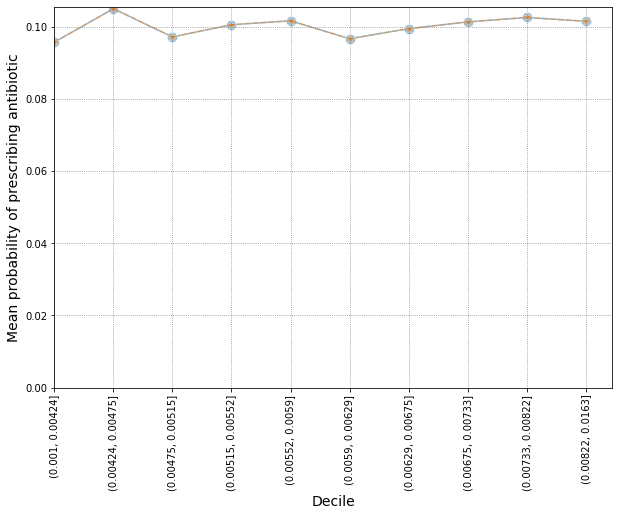


AUROC of LR for deciles with development and validation data: 0.50985 and 0.50399
AUROC of RF for deciles with development and validation data: 0.51721 and 0.50540
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.001, 0.00424]    0.107432  0.100963  0.114315
bins_(0.00424, 0.00475]  0.116052  0.109257  0.123270
bins_(0.00475, 0.00515]  0.105657  0.099258  0.112470
bins_(0.00515, 0.00552]  0.110896  0.104264  0.117950
bins_(0.00552, 0.0059]   0.114809  0.107994  0.122055
bins_(0.0059, 0.00629]   0.105179  0.098760  0.112016
bins_(0.00629, 0.00675]  0.110422  0.103820  0.117443
bins_(0.00675, 0.00733]  0.112632  0.105925  0.119763
bins_(0.00733, 0.00822]  0.115394  0.108558  0.122662
bins_(0.00822, 0.0163]   0.111339  0.104660  0.118444
antibacterial_brit       1.005001  0.991815  1.018362

RF feature importance:
                           rf_coef
antibacterial_brit       0.609524
bins_(0.0059, 0.00629]   0.064967
bins_(0.00733, 0.00822]  0.058956
bins_(0.

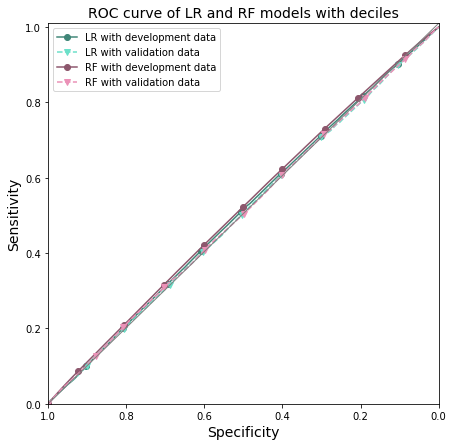

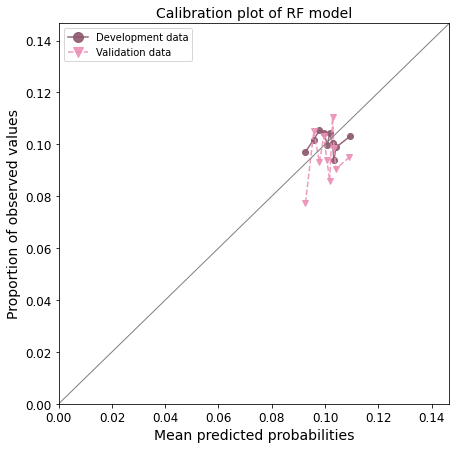

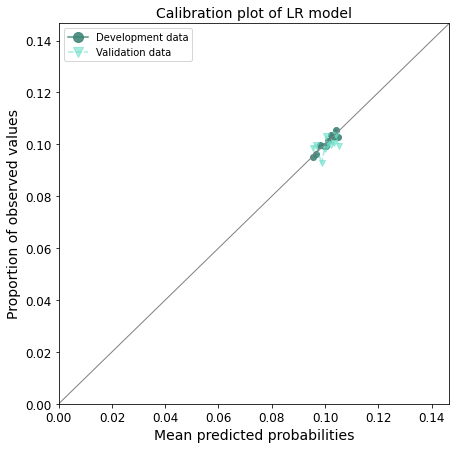


AUROC of LR for risk factors with development and validation data: 0.51359 and 0.49855
AUROC of RF for risk factors with development and validation data: 0.63181 and 0.49580
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.879794       NaN       NaN
age_cat_25_34                0.887060       NaN       NaN
age_cat_35_44                0.869196       NaN       NaN
age_cat_45_54                0.915741       NaN       NaN
age_cat_55_64                0.879812       NaN       NaN
age_cat_65_74                0.874712       NaN       NaN
age_cat_75_more              0.882405       NaN       NaN
sex_female                   0.644882       NaN       NaN
sex_male                     0.654134       NaN       NaN
CCI_cat_high                 0.829473       NaN       NaN
CCI_cat_low                  0.857245       NaN       NaN
CCI_cat_medium               0.818487       NaN       NaN
CCI_cat_very_high            0.868797       NaN      

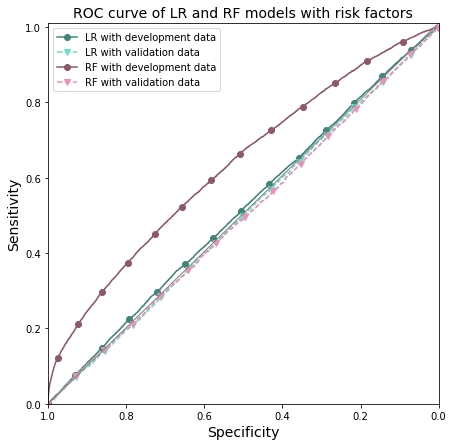

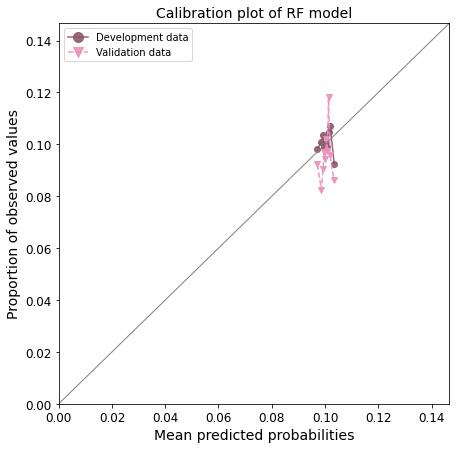

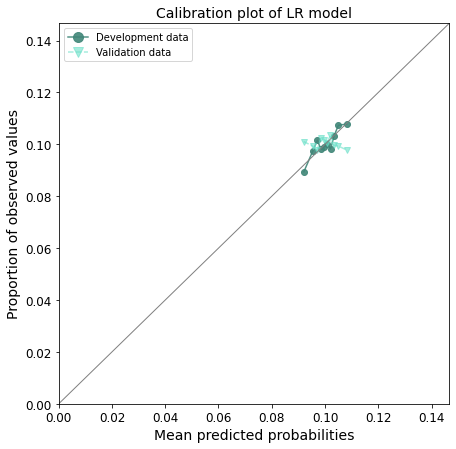

In [37]:
#build cox model for hosp prediction using non ab users' data
prob_pred_ot_externa_no_abs_incdt, prob_pred_ot_externa_no_abs_incdt_bin = cox_build('ot_externa', 'incdt', data_ot_externa_incdt, data_ot_externa_no_abs_incdt)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_deciles('ot_externa', 'incdt_deciles', prob_pred_ot_externa_no_abs_incdt)

#make summary table of deciles
make_summary_table_deciles('ot_externa', 'incdt', prob_pred_enc_lr_rf_incdt)

#calibration plots of rf and lr with deciles
calibration_rf_lr('ot_externa', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_riskfactors('ot_externa', 'incdt_riskfactors', prob_pred_ot_externa_no_abs_incdt)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('ot_externa', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 11858 total observations, 11772 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 11858
number of events observed = 86
   partial log-likelihood = -786.60
         time fit was run = 2023-06-28 14:54:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.40       0.67       0.30            -0.98             0.19                 0.37                 1.21
CCI_cat[T.medium]               -0.17       0.85       0.32            -0.80             0.46                 0.45                 1.59
CCI_cat[T.high]                 -0.38       0.68       0.42            -1.21             0.44                 0.30                 1.56
CCI_cat[T.very_high]            -0.53       0.59       0.38            -1.27             0.22                 0.28                 1.24
age_cat[T.25_34]                 0.43       1.54       0.53            -0.61             1.46                 0.55                 4.32
age_cat[T.35_44]                 0.56       1.75       0.51            -0.43             1.56                 0.65                 4.75
age_cat[T.45_54]                 1.16       3.18       0.47             0.25             2.07                 1.28                 7.94
age_cat[T.55_64]                 0.66       1.94       0.50            -0.32             1.64                 0.73                 5.17
age_cat[T.65_74]                 1.10       2.99       0.48             0.16             2.03                 1.18                 7.60
age_cat[T.75_more]               0.55       1.73       0.51            -0.45             1.54                 0.64                 4.67
antibacterial_brit              -0.01       0.99       0.08            -0.16             0.14                 0.86                 1.15
bmi_cat[T.obese]                -0.82       0.44       0.32            -1.45            -0.18                 0.23                 0.83
bmi_cat[T.overweight]           -0.71       0.49       0.44            -1.56             0.14                 0.21                 1.15
bmi_cat[T.underweight]          -0.68       0.51       0.64            -1.94             0.58                 0.14                 1.79
bmi_cat[T.unknown]              -0.61       0.54       0.35            -1.30             0.07                 0.27                 1.07
ethnicity[T.other]               0.52       1.69       0.63            -0.71             1.75                 0.49                 5.78
ethnicity[T.unknown]             0.62       1.87       0.54            -0.43             1.68                 0.65                 5.38
ethnicity[T.white]               0.44       1.56       0.52            -0.58             1.47                 0.56                 4.33
flu_vaccine[T.yes]               0.48       1.61       0.30            -0.11             1.07                 0.89                 2.91
imd[T.medium]                   -0.23       0.80       0.37            -0.96             0.50                 0.38                 1.66
imd[T.unaffluent]                0.25       1.28       0.34            -0.42             0.91                 0.66                 2.49
imd[T.unknown]                  -0.02       0.98       0.56            -1.12             1.08                 0.33                 2.94
imd[T.very_affluent]            -0.05       0.95       0.36            -0.75             0.66                 0.47                 1.93
imd[T.very_unaffluent]           0.24       1.27       0.34            -0.43             0.90                 0.65                 2.47
region[T.east_midlands]          0.21       1.23       0.4

13059


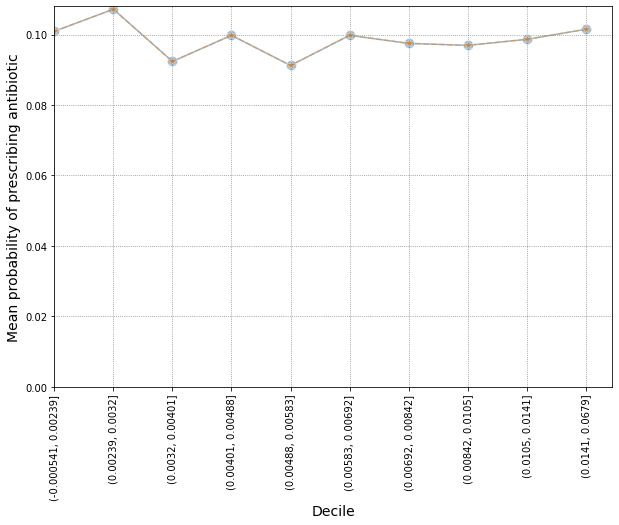


AUROC of LR for deciles with development and validation data: 0.51854 and 0.49392
AUROC of RF for deciles with development and validation data: 0.54890 and 0.51061
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.000541, 0.00239]  0.111012  0.092190  0.133678
bins_(0.00239, 0.0032]     0.123795  0.103363  0.148266
bins_(0.0032, 0.00401]     0.101952  0.083938  0.123832
bins_(0.00401, 0.00488]    0.116755  0.097010  0.140520
bins_(0.00488, 0.00583]    0.102832  0.084703  0.124841
bins_(0.00583, 0.00692]    0.109578  0.090916  0.132071
bins_(0.00692, 0.00842]    0.118748  0.098674  0.142906
bins_(0.00842, 0.0105]     0.110089  0.091063  0.133090
bins_(0.0105, 0.0141]      0.111709  0.092523  0.134873
bins_(0.0141, 0.0679]      0.119461  0.099469  0.143472
antibacterial_brit         0.988188  0.949361  1.028603

RF feature importance:
                             rf_coef
antibacterial_brit         0.600826
bins_(0.0141, 0.0679]      0.060758
bins_(0.0084

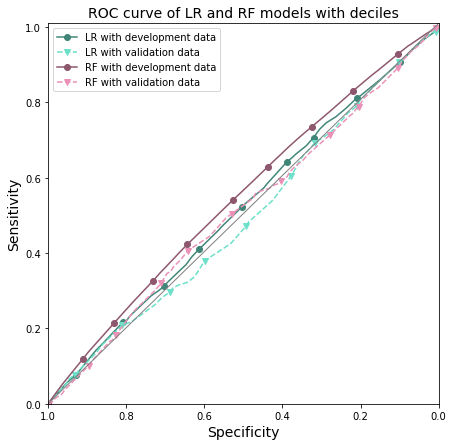

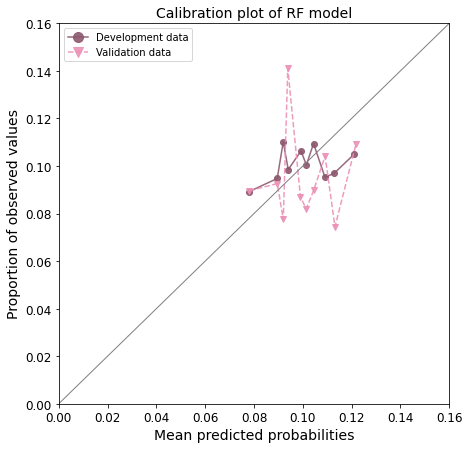

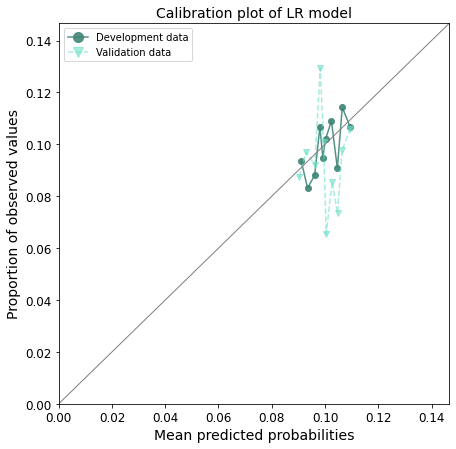


AUROC of LR for risk factors with development and validation data: 0.54835 and 0.48894
AUROC of RF for risk factors with development and validation data: 0.80695 and 0.50186
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.924894  0.000000       inf
age_cat_25_34                0.850935  0.000000       inf
age_cat_35_44                0.868124  0.000000       inf
age_cat_45_54                0.920357  0.000000       inf
age_cat_55_64                0.891179  0.000000       inf
age_cat_65_74                0.975316  0.000000       inf
age_cat_75_more              0.786046  0.000000       inf
sex_female                   0.653912  0.000000       inf
sex_male                     0.657001  0.000000       inf
CCI_cat_high                 0.759335       NaN       NaN
CCI_cat_low                  0.777372       NaN       NaN
CCI_cat_medium               0.876790       NaN       NaN
CCI_cat_very_high            0.917941       NaN      

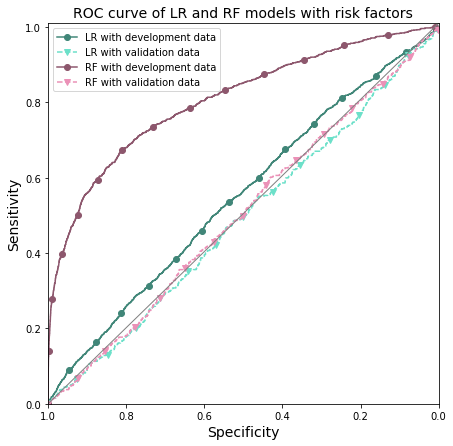

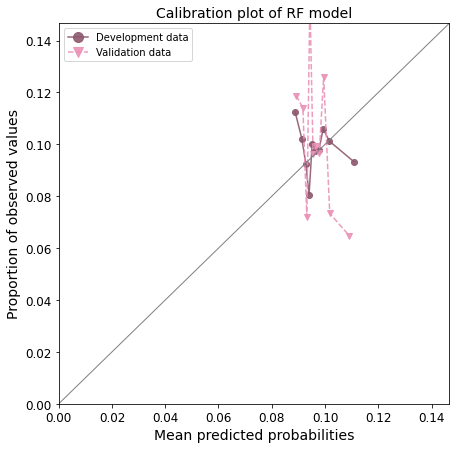

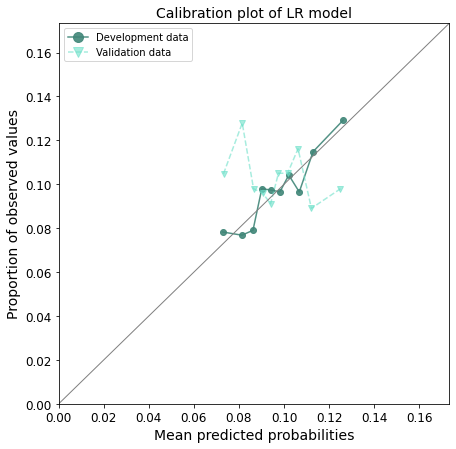

In [38]:
#build cox model for hosp prediction using non ab users' data
prob_pred_ot_externa_no_abs_prevl, prob_pred_ot_externa_no_abs_prevl_bin = cox_build('ot_externa', 'prevl', data_ot_externa_prevl, data_ot_externa_no_abs_prevl)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_deciles('ot_externa', 'prevl_deciles', prob_pred_ot_externa_no_abs_prevl)

#make summary table of deciles
make_summary_table_deciles('ot_externa', 'prevl', prob_pred_enc_lr_rf_prevl)

#calibration plots of rf and lr with deciles
calibration_rf_lr('ot_externa', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_riskfactors('ot_externa', 'prevl_riskfactors', prob_pred_ot_externa_no_abs_prevl)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('ot_externa', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 29035 total observations, 28877 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 29035
number of events observed = 158
   partial log-likelihood = -1601.98
         time fit was run = 2023-06-28 14:55:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.36       1.43       0.24            -0.12             0.83                 0.89                 2.29
CCI_cat[T.medium]               -0.18       0.83       0.29            -0.75             0.39                 0.47                 1.48
CCI_cat[T.high]                 -0.21       0.81       0.36            -0.91             0.48                 0.40                 1.62
CCI_cat[T.very_high]             0.19       1.20       0.28            -0.37             0.74                 0.69                 2.09
age_cat[T.25_34]                 0.23       1.25       0.30            -0.35             0.81                 0.70                 2.24
age_cat[T.35_44]                -0.10       0.91       0.32            -0.72             0.52                 0.49                 1.69
age_cat[T.45_54]                 0.07       1.07       0.31            -0.53             0.67                 0.59                 1.95
age_cat[T.55_64]                 0.14       1.15       0.30            -0.45             0.73                 0.64                 2.06
age_cat[T.65_74]                 0.29       1.34       0.29            -0.28             0.87                 0.76                 2.38
age_cat[T.75_more]              -0.01       0.99       0.31            -0.62             0.61                 0.54                 1.83
antibacterial_brit               0.03       1.03       0.06            -0.08             0.14                 0.93                 1.15
bmi_cat[T.obese]                -0.10       0.90       0.30            -0.69             0.49                 0.50                 1.63
bmi_cat[T.overweight]           -0.40       0.67       0.40            -1.19             0.39                 0.31                 1.47
bmi_cat[T.underweight]           0.62       1.87       0.42            -0.20             1.45                 0.82                 4.26
bmi_cat[T.unknown]               0.16       1.18       0.31            -0.45             0.78                 0.64                 2.18
ethnicity[T.other]               0.57       1.76       0.44            -0.30             1.44                 0.74                 4.20
ethnicity[T.unknown]             0.56       1.74       0.38            -0.19             1.30                 0.82                 3.69
ethnicity[T.white]               0.31       1.37       0.37            -0.41             1.04                 0.66                 2.82
flu_vaccine[T.yes]              -0.86       0.42       0.39            -1.62            -0.10                 0.20                 0.90
imd[T.medium]                   -0.14       0.87       0.25            -0.63             0.36                 0.53                 1.44
imd[T.unaffluent]               -0.21       0.81       0.26            -0.72             0.30                 0.49                 1.35
imd[T.unknown]                  -0.41       0.66       0.44            -1.29             0.46                 0.28                 1.58
imd[T.very_affluent]            -0.13       0.88       0.25            -0.63             0.37                 0.53                 1.45
imd[T.very_unaffluent]           0.02       1.02       0.24            -0.46             0.50                 0.63                 1.64
region[T.east_midlands]          0.18       1.20       0

13053


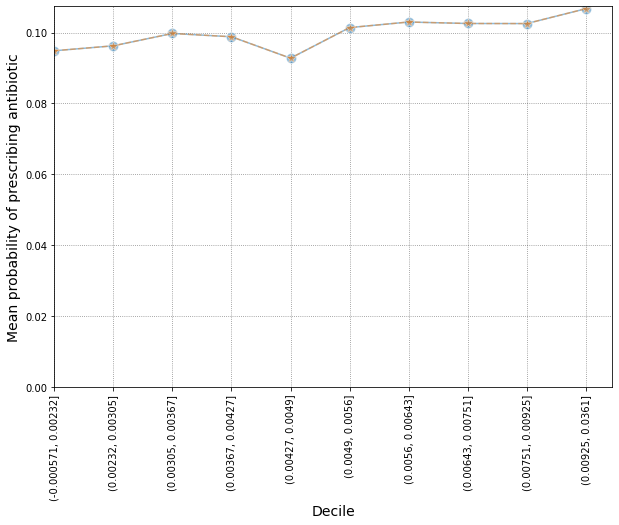


AUROC of LR for deciles with development and validation data: 0.52212 and 0.48703
AUROC of RF for deciles with development and validation data: 0.53750 and 0.49586
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.000571, 0.00232]  0.094622  0.083347  0.107423
bins_(0.00232, 0.00305]    0.103801  0.091943  0.117189
bins_(0.00305, 0.00367]    0.113657  0.101016  0.127881
bins_(0.00367, 0.00427]    0.105705  0.093532  0.119462
bins_(0.00427, 0.0049]     0.104704  0.092619  0.118366
bins_(0.0049, 0.0056]      0.116295  0.103300  0.130925
bins_(0.0056, 0.00643]     0.115525  0.102619  0.130054
bins_(0.00643, 0.00751]    0.116696  0.103638  0.131400
bins_(0.00751, 0.00925]    0.116369  0.103231  0.131179
bins_(0.00925, 0.0361]     0.120092  0.106740  0.135114
antibacterial_brit         0.986036  0.960719  1.012020

RF feature importance:
                             rf_coef
antibacterial_brit         0.565839
bins_(-0.000571, 0.00232]  0.090174
bins_(0.0064

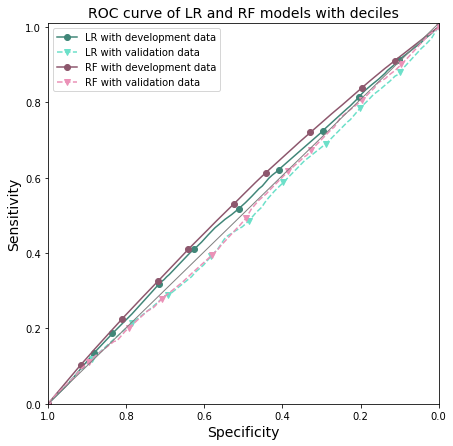

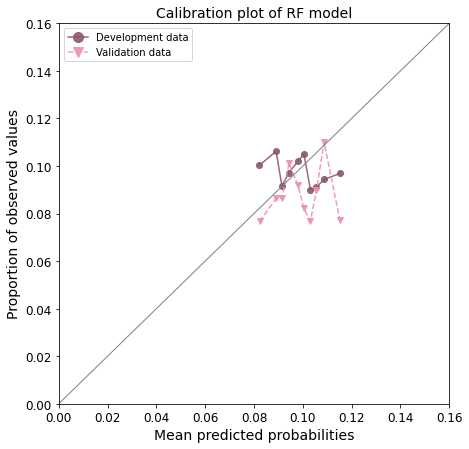

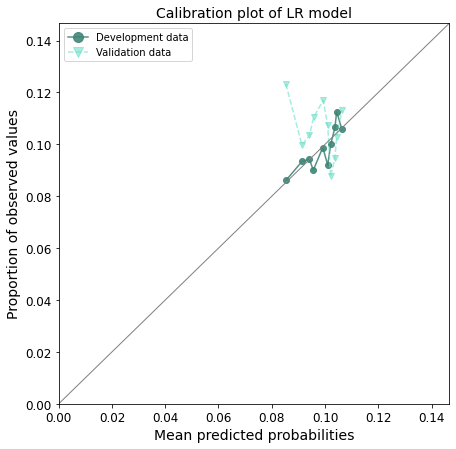

In [39]:
#build cox model for hosp prediction using non ab users' data
prob_pred_ot_externa_no_abs_incdt_prepandemic, prob_pred_ot_externa_no_abs_incdt_prepandemic_bin = cox_build('ot_externa', 'incdt_prepandemic', data_ot_externa_incdt_prepandemic, data_ot_externa_no_abs_incdt_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('ot_externa', 'incdt_prepandemic', prob_pred_ot_externa_no_abs_incdt_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('ot_externa', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)

<lifelines.CoxPHFitter: fitted with 33207 total observations, 33005 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 33207
number of events observed = 202
   partial log-likelihood = -2076.35
         time fit was run = 2023-06-28 14:55:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.19       0.83       0.22            -0.62             0.25                 0.54                 1.28
CCI_cat[T.medium]                0.31       1.37       0.22            -0.13             0.75                 0.88                 2.11
CCI_cat[T.high]                  0.43       1.54       0.25            -0.06             0.92                 0.94                 2.52
CCI_cat[T.very_high]            -0.10       0.91       0.26            -0.60             0.41                 0.55                 1.50
age_cat[T.25_34]                 0.62       1.85       0.29             0.04             1.19                 1.04                 3.29
age_cat[T.35_44]                 0.67       1.95       0.29             0.10             1.24                 1.10                 3.45
age_cat[T.45_54]                 0.71       2.04       0.29             0.15             1.28                 1.16                 3.61
age_cat[T.55_64]                 0.33       1.39       0.31            -0.28             0.93                 0.76                 2.54
age_cat[T.65_74]                 0.53       1.71       0.30            -0.05             1.12                 0.95                 3.06
age_cat[T.75_more]               0.41       1.51       0.31            -0.19             1.02                 0.83                 2.76
antibacterial_brit              -0.02       0.98       0.05            -0.12             0.08                 0.89                 1.08
bmi_cat[T.obese]                 0.23       1.26       0.29            -0.35             0.81                 0.71                 2.24
bmi_cat[T.overweight]            0.23       1.25       0.35            -0.45             0.91                 0.64                 2.48
bmi_cat[T.underweight]           0.42       1.53       0.45            -0.46             1.31                 0.63                 3.69
bmi_cat[T.unknown]               0.28       1.33       0.31            -0.32             0.89                 0.72                 2.43
ethnicity[T.other]               0.22       1.25       0.37            -0.51             0.96                 0.60                 2.61
ethnicity[T.unknown]            -0.09       0.91       0.32            -0.72             0.53                 0.49                 1.71
ethnicity[T.white]               0.25       1.28       0.29            -0.32             0.82                 0.73                 2.27
flu_vaccine[T.yes]               0.14       1.16       0.22            -0.29             0.58                 0.75                 1.78
imd[T.medium]                   -0.22       0.81       0.26            -0.73             0.30                 0.48                 1.34
imd[T.unaffluent]                0.26       1.30       0.23            -0.19             0.71                 0.83                 2.03
imd[T.unknown]                   0.41       1.51       0.33            -0.23             1.05                 0.80                 2.87
imd[T.very_affluent]             0.24       1.28       0.23            -0.21             0.69                 0.81                 2.00
imd[T.very_unaffluent]           0.27       1.30       0.23            -0.19             0.72                 0.83                 2.05
region[T.east_midlands]          0.64       1.89       0

13028


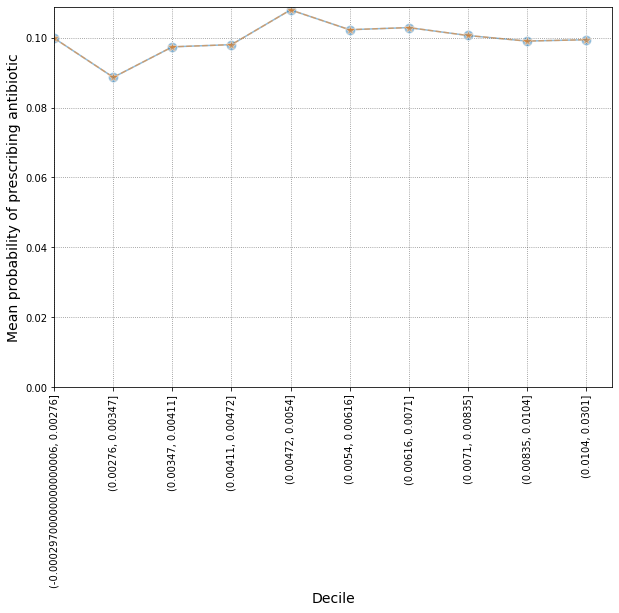


AUROC of LR for deciles with development and validation data: 0.51159 and 0.50965
AUROC of RF for deciles with development and validation data: 0.53110 and 0.50456
LR coefficients:
                                                OR  Lower CI  Upper CI
bins_(-0.00029700000000000006, 0.00276]  0.114801  0.102675  0.128358
bins_(0.00276, 0.00347]                  0.096795  0.086031  0.108906
bins_(0.00347, 0.00411]                  0.109043  0.097403  0.122075
bins_(0.00411, 0.00472]                  0.111031  0.099309  0.124135
bins_(0.00472, 0.0054]                   0.116926  0.104859  0.130382
bins_(0.0054, 0.00616]                   0.111849  0.100091  0.124989
bins_(0.00616, 0.0071]                   0.111850  0.100099  0.124981
bins_(0.0071, 0.00835]                   0.112119  0.100439  0.125157
bins_(0.00835, 0.0104]                   0.108675  0.097114  0.121612
bins_(0.0104, 0.0301]                    0.113738  0.101870  0.126990
antibacterial_brit                       1.0029

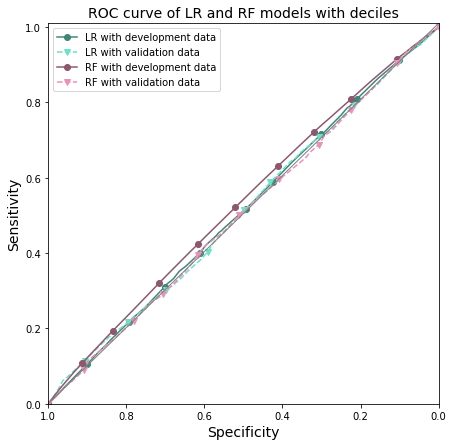

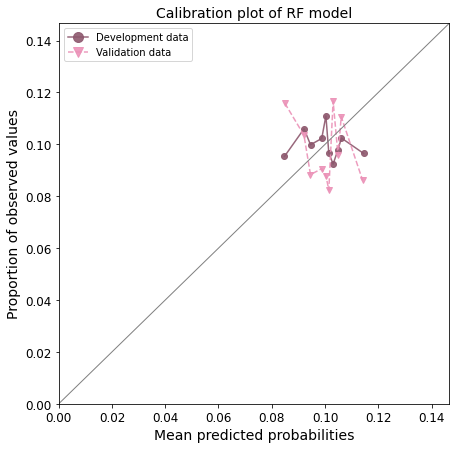

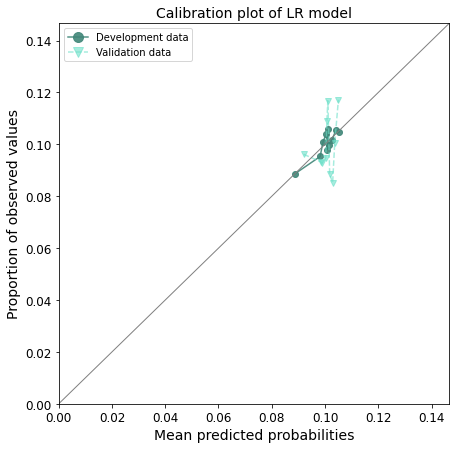

In [40]:
#build cox model for hosp prediction using non ab users' data
prob_pred_ot_externa_no_abs_incdt_during_pandemic, prob_pred_ot_externa_no_abs_incdt_during_pandemic_bin = cox_build('ot_externa', 'incdt_during_pandemic', data_ot_externa_incdt_during_pandemic, data_ot_externa_no_abs_incdt_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('ot_externa', 'incdt_during_pandemic', prob_pred_ot_externa_no_abs_incdt_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('ot_externa', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)

<lifelines.CoxPHFitter: fitted with 46150 total observations, 45819 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 46150
number of events observed = 331
   partial log-likelihood = -3537.72
         time fit was run = 2023-06-28 14:56:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.91       0.16            -0.40             0.22                 0.67                 1.24
CCI_cat[T.medium]               -0.05       0.95       0.17            -0.39             0.29                 0.68                 1.34
CCI_cat[T.high]                 -0.29       0.75       0.23            -0.74             0.15                 0.48                 1.16
CCI_cat[T.very_high]            -0.20       0.82       0.19            -0.57             0.17                 0.56                 1.19
age_cat[T.25_34]                 0.31       1.36       0.20            -0.08             0.70                 0.92                 2.01
age_cat[T.35_44]                 0.01       1.01       0.21            -0.40             0.42                 0.67                 1.53
age_cat[T.45_54]                -0.04       0.96       0.21            -0.46             0.38                 0.63                 1.46
age_cat[T.55_64]                -0.08       0.92       0.22            -0.51             0.34                 0.60                 1.40
age_cat[T.65_74]                -0.17       0.84       0.22            -0.61             0.26                 0.54                 1.30
age_cat[T.75_more]               0.27       1.31       0.20            -0.12             0.66                 0.89                 1.94
antibacterial_brit               0.07       1.07       0.04            -0.00             0.14                 1.00                 1.16
bmi_cat[T.obese]                 0.05       1.05       0.21            -0.36             0.45                 0.70                 1.58
bmi_cat[T.overweight]           -0.16       0.85       0.26            -0.68             0.35                 0.51                 1.42
bmi_cat[T.underweight]           0.02       1.02       0.36            -0.68             0.72                 0.51                 2.06
bmi_cat[T.unknown]              -0.03       0.97       0.22            -0.47             0.40                 0.62                 1.49
ethnicity[T.other]              -0.02       0.98       0.27            -0.55             0.50                 0.57                 1.66
ethnicity[T.unknown]            -0.23       0.80       0.22            -0.66             0.21                 0.52                 1.23
ethnicity[T.white]              -0.11       0.89       0.20            -0.51             0.28                 0.60                 1.33
flu_vaccine[T.yes]               0.07       1.07       0.18            -0.28             0.42                 0.76                 1.52
imd[T.medium]                    0.02       1.02       0.18            -0.32             0.37                 0.72                 1.44
imd[T.unaffluent]               -0.11       0.90       0.18            -0.46             0.25                 0.63                 1.28
imd[T.unknown]                   0.18       1.19       0.26            -0.33             0.68                 0.72                 1.97
imd[T.very_affluent]             0.08       1.09       0.17            -0.26             0.42                 0.77                 1.52
imd[T.very_unaffluent]          -0.16       0.85       0.18            -0.52             0.20                 0.59                 1.22
region[T.east_midlands]          0.43       1.54       0

13052


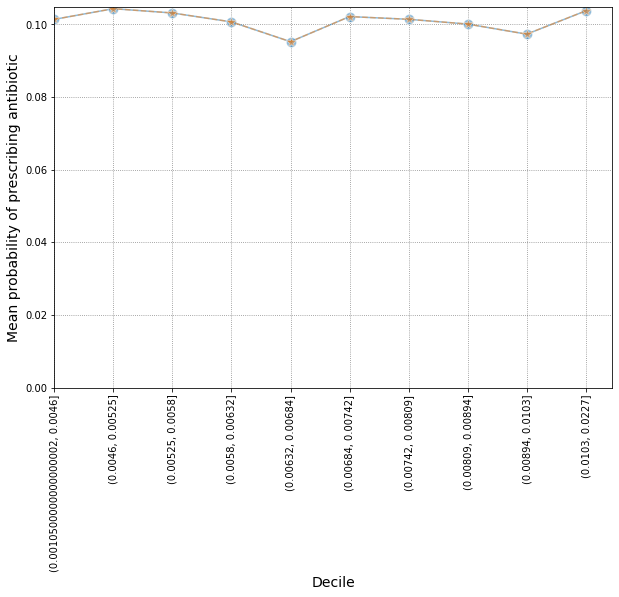


AUROC of LR for deciles with development and validation data: 0.50912 and 0.50712
AUROC of RF for deciles with development and validation data: 0.52451 and 0.49828
LR coefficients:
                                             OR  Lower CI  Upper CI
bins_(0.0010500000000000002, 0.0046]  0.110662  0.100947  0.121312
bins_(0.0046, 0.00525]                0.115109  0.105055  0.126125
bins_(0.00525, 0.0058]                0.112681  0.102785  0.123528
bins_(0.0058, 0.00632]                0.113187  0.103119  0.124239
bins_(0.00632, 0.00684]               0.105571  0.095925  0.116188
bins_(0.00684, 0.00742]               0.111153  0.101139  0.122158
bins_(0.00742, 0.00809]               0.112558  0.102337  0.123800
bins_(0.00809, 0.00894]               0.107094  0.097130  0.118080
bins_(0.00894, 0.0103]                0.104680  0.094698  0.115713
bins_(0.0103, 0.0227]                 0.112005  0.101227  0.123931
antibacterial_brit                    1.009591  0.988389  1.031249

RF feature i

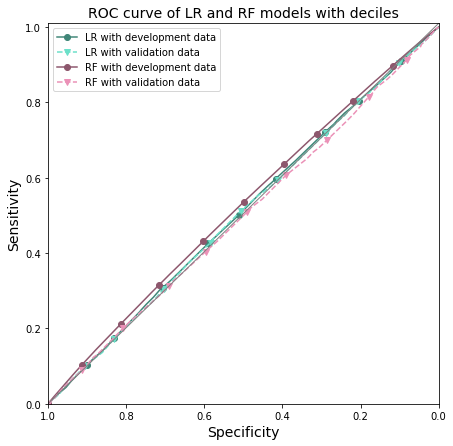

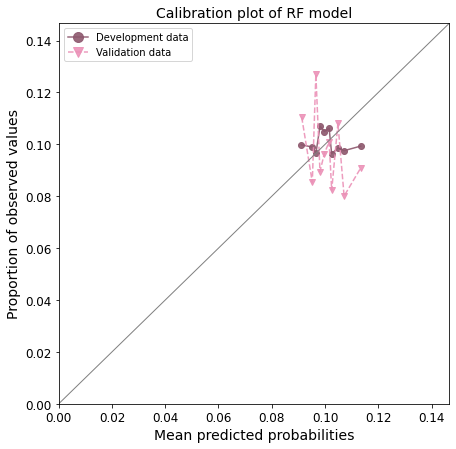

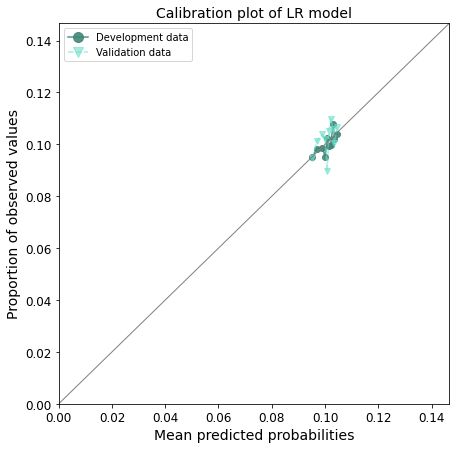

In [41]:
#build cox model for hosp prediction using non ab users' data
prob_pred_ot_externa_no_abs_incdt_post_2nd_lockdown, prob_pred_ot_externa_no_abs_incdt_post_2nd_lockdown_bin = cox_build('ot_externa', 'incdt_post_2nd_lockdown', data_ot_externa_incdt_post_2nd_lockdown, data_ot_externa_no_abs_incdt_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('ot_externa', 'incdt_post_2nd_lockdown', prob_pred_ot_externa_no_abs_incdt_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('ot_externa', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3099 total observations, 3085 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 3099
number of events observed = 14
   partial log-likelihood = -92.81
         time fit was run = 2023-06-28 14:56:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.26       0.77       0.72            -1.66             1.14                 0.19                 3.13
CCI_cat[T.medium]               -1.49       0.23       1.17            -3.78             0.80                 0.02                 2.22
CCI_cat[T.high]                 -1.03       0.36       1.18            -3.34             1.28                 0.04                 3.58
CCI_cat[T.very_high]            -0.71       0.49       0.94            -2.55             1.13                 0.08                 3.11
age_cat[T.25_34]                 0.73       2.07       1.24            -1.70             3.16                 0.18                23.52
age_cat[T.35_44]                 0.01       1.01       1.42            -2.78             2.81                 0.06                16.56
age_cat[T.45_54]                 0.84       2.31       1.17            -1.44             3.12                 0.24                22.72
age_cat[T.55_64]                -0.16       0.85       1.44            -2.98             2.66                 0.05                14.24
age_cat[T.65_74]                 1.53       4.60       1.11            -0.65             3.70                 0.52                40.40
age_cat[T.75_more]              -0.02       0.98       1.42            -2.81             2.78                 0.06                16.04
antibacterial_brit               0.18       1.19       0.19            -0.19             0.54                 0.83                 1.72
bmi_cat[T.obese]                -0.07       0.93       1.11            -2.25             2.10                 0.11                 8.20
bmi_cat[T.overweight]            0.91       2.48       1.19            -1.42             3.23                 0.24                25.34
bmi_cat[T.underweight]         -17.75       0.00   12332.30        -24188.61         24153.11                 0.00                  inf
bmi_cat[T.unknown]               0.66       1.94       1.12            -1.54             2.86                 0.22                17.49
ethnicity[T.other]               0.33       1.39   10117.46        -19829.53         19830.19                 0.00                  inf
ethnicity[T.unknown]            18.15   7.60e+07    7379.46        -14445.34         14481.63                 0.00                  inf
ethnicity[T.white]              18.22   8.15e+07    7379.46        -14445.27         14481.70                 0.00                  inf
flu_vaccine[T.yes]               0.65       1.92       0.68            -0.67             1.98                 0.51                 7.22
imd[T.medium]                   -1.40       0.25       1.14            -3.63             0.83                 0.03                 2.29
imd[T.unaffluent]               -0.80       0.45       0.89            -2.54             0.94                 0.08                 2.57
imd[T.unknown]                 -18.31       0.00    8455.36        -16590.51         16553.89                 0.00                  inf
imd[T.very_affluent]            -0.27       0.76       0.78            -1.81             1.26                 0.16                 3.54
imd[T.very_unaffluent]          -0.01       0.99       0.73            -1.43             1.42                 0.24                 4.13
region[T.east_midlands]        -19.42       0.00    8269.09   

13173


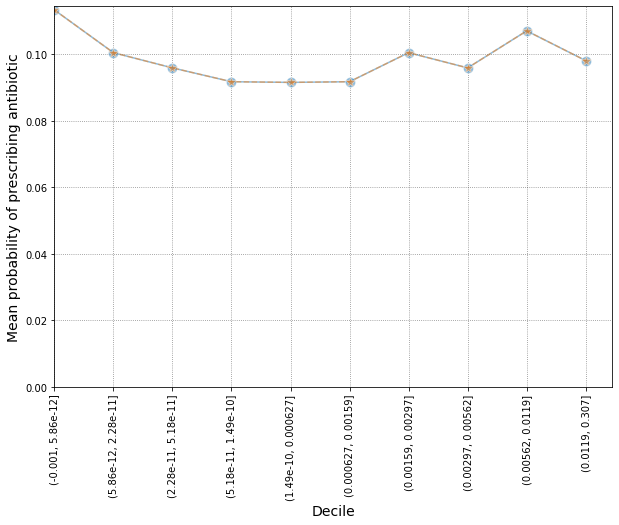


AUROC of LR for deciles with development and validation data: 0.54200 and 0.45474
AUROC of RF for deciles with development and validation data: 0.59082 and 0.48708
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.001, 5.86e-12]    0.108426  0.075071  0.156600
bins_(0.000627, 0.00159]   0.096703  0.066678  0.140249
bins_(0.00159, 0.00297]    0.120507  0.084898  0.171053
bins_(0.00297, 0.00562]    0.070652  0.045709  0.109207
bins_(0.00562, 0.0119]     0.109091  0.075323  0.157997
bins_(0.0119, 0.307]       0.108277  0.074659  0.157033
bins_(1.49e-10, 0.000627]  0.089352  0.059834  0.133432
bins_(2.28e-11, 5.18e-11]  0.093480  0.063789  0.136990
bins_(5.18e-11, 1.49e-10]  0.088464  0.059996  0.130440
bins_(5.86e-12, 2.28e-11]  0.102204  0.070311  0.148566
antibacterial_brit         1.032600  0.952146  1.119852

RF feature importance:
                             rf_coef
antibacterial_brit         0.579104
bins_(0.00297, 0.00562]    0.057336
bins_(0.0015

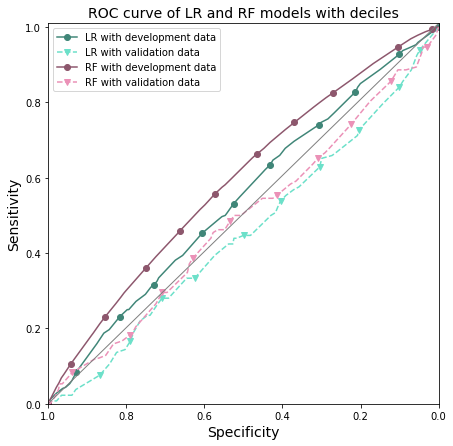

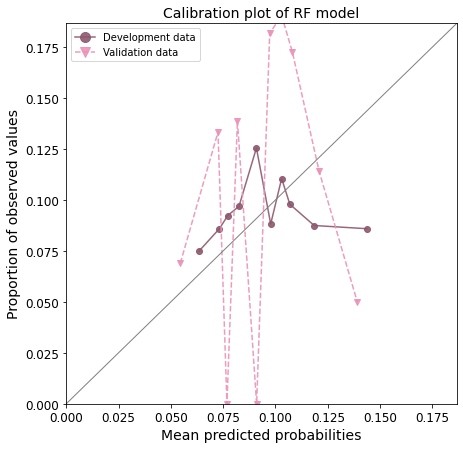

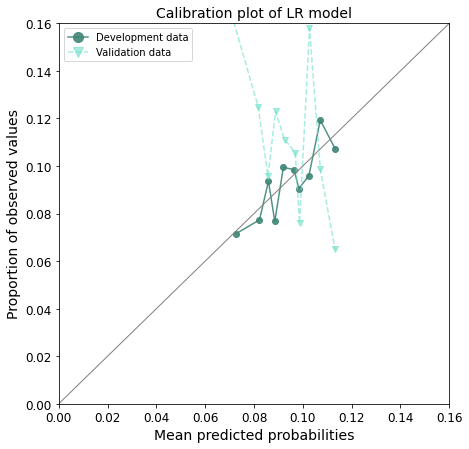

In [42]:
#build cox model for hosp prediction using non ab users' data
prob_pred_ot_externa_no_abs_prevl_prepandemic, prob_pred_ot_externa_no_abs_prevl_prepandemic_bin = cox_build('ot_externa', 'prevl_prepandemic', data_ot_externa_prevl_prepandemic, data_ot_externa_no_abs_prevl_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('ot_externa', 'prevl_prepandemic', prob_pred_ot_externa_no_abs_prevl_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('ot_externa', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)

<lifelines.CoxPHFitter: fitted with 3665 total observations, 3646 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 3665
number of events observed = 19
   partial log-likelihood = -135.83
         time fit was run = 2023-06-28 14:56:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.62            -1.19             1.25                 0.30                 3.49
CCI_cat[T.medium]               -0.26       0.77       0.72            -1.68             1.16                 0.19                 3.18
CCI_cat[T.high]                -18.16       0.00    4899.12         -9620.25          9583.93                 0.00                  inf
CCI_cat[T.very_high]            -0.32       0.72       0.78            -1.85             1.20                 0.16                 3.33
age_cat[T.25_34]                 1.14       3.12       1.17            -1.15             3.43                 0.32                30.75
age_cat[T.35_44]                 0.77       2.15       1.23            -1.65             3.19                 0.19                24.20
age_cat[T.45_54]                 0.94       2.57       1.17            -1.34             3.23                 0.26                25.23
age_cat[T.55_64]                 1.63       5.10       1.11            -0.54             3.80                 0.58                44.58
age_cat[T.65_74]                -0.08       0.92       1.43            -2.88             2.71                 0.06                15.04
age_cat[T.75_more]               1.29       3.64       1.13            -0.91             3.50                 0.40                33.10
antibacterial_brit              -0.06       0.94       0.17            -0.39             0.27                 0.68                 1.31
bmi_cat[T.obese]                -1.50       0.22       0.75            -2.96            -0.04                 0.05                 0.96
bmi_cat[T.overweight]           -0.32       0.73       0.84            -1.96             1.33                 0.14                 3.79
bmi_cat[T.underweight]         -18.78       0.00   10456.84        -20513.81         20476.25                 0.00                  inf
bmi_cat[T.unknown]              -0.30       0.74       0.69            -1.66             1.07                 0.19                 2.90
ethnicity[T.other]              -1.03       0.36       1.25            -3.48             1.42                 0.03                 4.14
ethnicity[T.unknown]            -0.72       0.49       0.89            -2.46             1.02                 0.09                 2.77
ethnicity[T.white]              -0.61       0.54       0.79            -2.15             0.93                 0.12                 2.54
flu_vaccine[T.yes]               1.34       3.81       0.54             0.29             2.39                 1.33                10.90
imd[T.medium]                   -0.32       0.72       0.78            -1.84             1.20                 0.16                 3.32
imd[T.unaffluent]                0.21       1.23       0.69            -1.14             1.55                 0.32                 4.73
imd[T.unknown]                   0.23       1.25       1.14            -2.00             2.46                 0.13                11.67
imd[T.very_affluent]             0.06       1.06       0.72            -1.36             1.48                 0.26                 4.38
imd[T.very_unaffluent]          -0.63       0.54       0.88            -2.36             1.10                 0.09                 3.02
region[T.east_midlands]          0.74       2.10       1.24  

13106


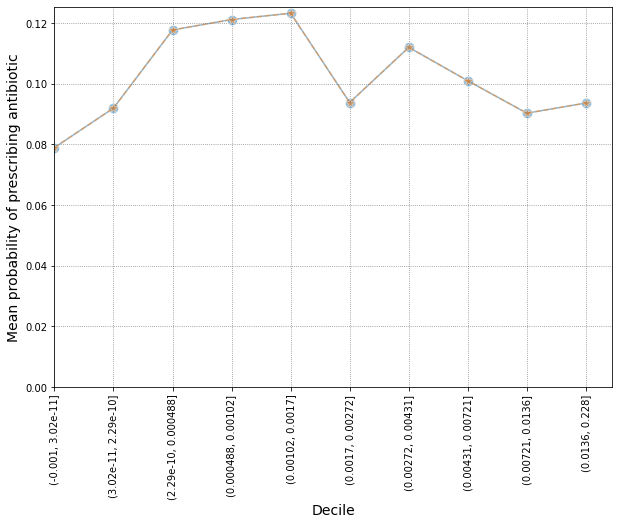


AUROC of LR for deciles with development and validation data: 0.55196 and 0.50732
AUROC of RF for deciles with development and validation data: 0.59268 and 0.50804
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.001, 3.02e-11]    0.089545  0.062215  0.128882
bins_(0.000488, 0.00102]   0.146135  0.107677  0.198330
bins_(0.00102, 0.0017]     0.149080  0.110087  0.201883
bins_(0.0017, 0.00272]     0.089527  0.061927  0.129428
bins_(0.00272, 0.00431]    0.118906  0.086325  0.163782
bins_(0.00431, 0.00721]    0.109787  0.078656  0.153237
bins_(0.00721, 0.0136]     0.087895  0.060974  0.126701
bins_(0.0136, 0.228]       0.103188  0.073286  0.145292
bins_(2.29e-10, 0.000488]  0.121656  0.087559  0.169030
bins_(3.02e-11, 2.29e-10]  0.098779  0.069380  0.140635
antibacterial_brit         1.003315  0.933842  1.077956

RF feature importance:
                             rf_coef
antibacterial_brit         0.598098
bins_(0.000488, 0.00102]   0.082245
bins_(0.0010

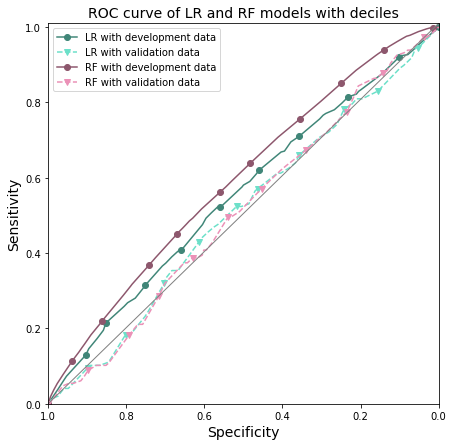

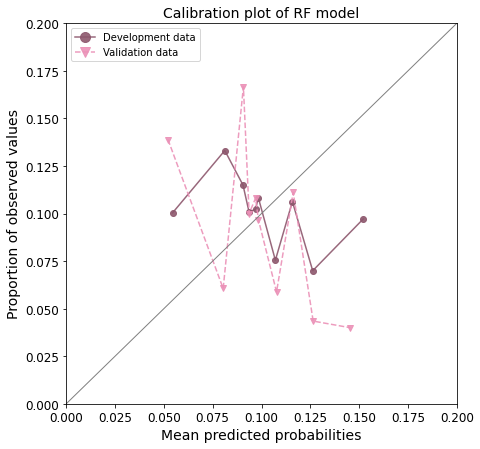

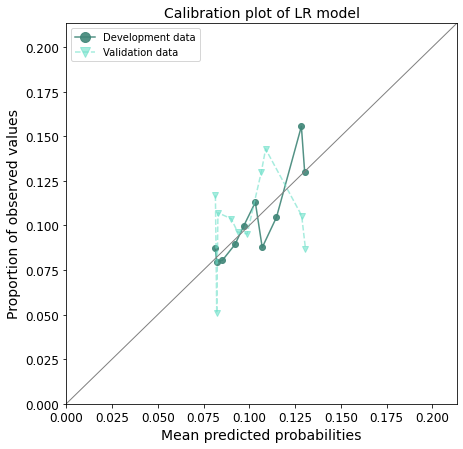

In [43]:
#build cox model for hosp prediction using non ab users' data
prob_pred_ot_externa_no_abs_prevl_during_pandemic, prob_pred_ot_externa_no_abs_prevl_during_pandemic_bin = cox_build('ot_externa', 'prevl_during_pandemic', data_ot_externa_prevl_during_pandemic, data_ot_externa_no_abs_prevl_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('ot_externa', 'prevl_during_pandemic', prob_pred_ot_externa_no_abs_prevl_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('ot_externa', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)

<lifelines.CoxPHFitter: fitted with 5093 total observations, 5052 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 5093
number of events observed = 41
   partial log-likelihood = -326.93
         time fit was run = 2023-06-28 14:57:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.35       0.70       0.49            -1.30             0.60                 0.27                 1.82
CCI_cat[T.medium]                0.17       1.18       0.50            -0.80             1.14                 0.45                 3.12
CCI_cat[T.high]                  0.32       1.37       0.56            -0.78             1.41                 0.46                 4.11
CCI_cat[T.very_high]             0.07       1.07       0.54            -0.99             1.12                 0.37                 3.06
age_cat[T.25_34]                -0.18       0.84       0.67            -1.50             1.14                 0.22                 3.14
age_cat[T.35_44]                -0.12       0.89       0.64            -1.37             1.12                 0.25                 3.07
age_cat[T.45_54]                 0.55       1.74       0.57            -0.57             1.68                 0.56                 5.35
age_cat[T.55_64]                 0.08       1.08       0.61            -1.12             1.27                 0.33                 3.57
age_cat[T.65_74]                 0.60       1.82       0.56            -0.51             1.70                 0.60                 5.47
age_cat[T.75_more]              -0.32       0.72       0.67            -1.65             1.00                 0.19                 2.72
antibacterial_brit              -0.08       0.92       0.11            -0.30             0.14                 0.74                 1.16
bmi_cat[T.obese]                -0.79       0.45       0.42            -1.61             0.03                 0.20                 1.03
bmi_cat[T.overweight]           -1.21       0.30       0.68            -2.54             0.13                 0.08                 1.14
bmi_cat[T.underweight]         -18.59       0.00    6398.64        -12559.70         12522.52                 0.00                  inf
bmi_cat[T.unknown]              -1.13       0.32       0.50            -2.12            -0.14                 0.12                 0.87
ethnicity[T.other]              18.07   7.03e+07    4093.76         -8005.56          8041.69                 0.00                  inf
ethnicity[T.unknown]            18.07   7.04e+07    4093.76         -8005.55          8041.69                 0.00                  inf
ethnicity[T.white]              17.77   5.21e+07    4093.76         -8005.86          8041.39                 0.00                  inf
flu_vaccine[T.yes]              -0.23       0.80       0.60            -1.41             0.96                 0.24                 2.60
imd[T.medium]                    0.49       1.63       0.57            -0.64             1.61                 0.53                 5.01
imd[T.unaffluent]                0.62       1.86       0.56            -0.48             1.72                 0.62                 5.58
imd[T.unknown]                  -0.14       0.87       1.10            -2.29             2.02                 0.10                 7.51
imd[T.very_affluent]             0.25       1.29       0.61            -0.94             1.44                 0.39                 4.24
imd[T.very_unaffluent]           0.88       2.40       0.53            -0.17             1.93                 0.84                 6.86
region[T.east_midlands]          1.26       3.53       0.81  

13099


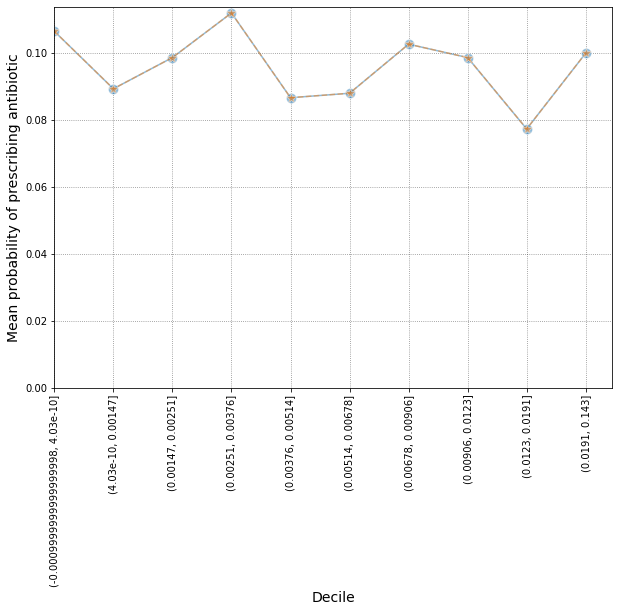


AUROC of LR for deciles with development and validation data: 0.53261 and 0.50672
AUROC of RF for deciles with development and validation data: 0.57324 and 0.53574
LR coefficients:
                                                OR  Lower CI  Upper CI
bins_(-0.0009999999999999998, 4.03e-10]  0.133377  0.101816  0.174722
bins_(0.00147, 0.00251]                  0.118463  0.089092  0.157517
bins_(0.00251, 0.00376]                  0.125934  0.095319  0.166383
bins_(0.00376, 0.00514]                  0.105227  0.078380  0.141270
bins_(0.00514, 0.00678]                  0.104994  0.078208  0.140956
bins_(0.00678, 0.00906]                  0.099992  0.073796  0.135488
bins_(0.00906, 0.0123]                   0.114553  0.086330  0.152003
bins_(0.0123, 0.0191]                    0.084572  0.060763  0.117712
bins_(0.0191, 0.143]                     0.119286  0.090347  0.157494
bins_(4.03e-10, 0.00147]                 0.113923  0.085439  0.151903
antibacterial_brit                       0.9727

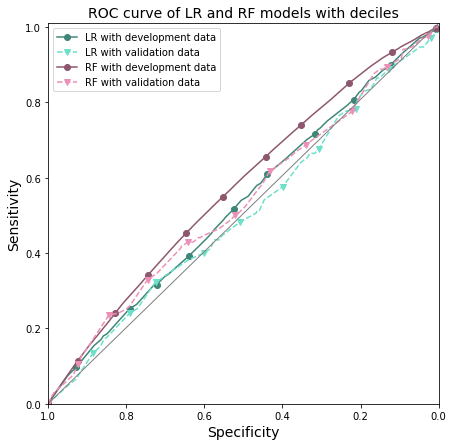

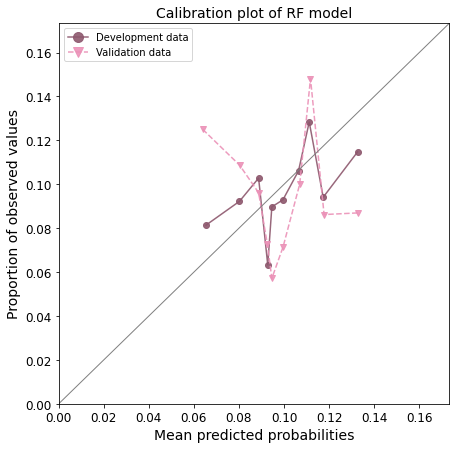

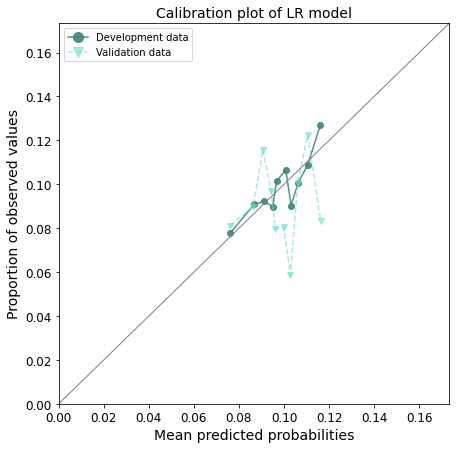

In [44]:
#build cox model for hosp prediction using non ab users' data
prob_pred_ot_externa_no_abs_prevl_post_2nd_lockdown, prob_pred_ot_externa_no_abs_prevl_post_2nd_lockdown_bin = cox_build('ot_externa', 'prevl_post_2nd_lockdown', data_ot_externa_prevl_post_2nd_lockdown, data_ot_externa_no_abs_prevl_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('ot_externa', 'prevl_post_2nd_lockdown', prob_pred_ot_externa_no_abs_prevl_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('ot_externa', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)